In [6]:
# ! pip install --upgrade emcee corner pytorch-lightning tqdm nflows

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner

/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <7702F607-92FA-3D67-9D09-0710D936B85A> /opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /opt/homebrew/Caskroom/miniforge/base/envs/cfm/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Simulation-based (likelihood-free) inference
**Siddharth Mishra-Sharma** ([smsharma@mit.edu](mailto:smsharma@mit.edu))

The likelihood function is central to performing inference / doing parameter estimation.

<img src=./assets/likelihood.png alt= “” width=800>

Simulation-based inference (SBI) is a powerful class of methods for performing inference in settings where the likelihood is computationally intractable (e.g., due to a high dimensional latent space, making the integral over $z$ intractable), but simulations can be realized via forward modeling. 

In this notebook we will
- Introduce the notion of an _implicit_ likelihood, and how to leverage it to perform inference;
- Look at a "traditional" method for likelihood-free inference, Approximate Bayesian Computation (ABC);
- Build up two common modern _neural_ SBI techniques: neural likelihood-ratio estimation (NRE) and neural posterior estimation (NPE);
- Introduce the concept of statistical coverage testing and calibration.

As examples, we will look at a simple Gaussian-signal-on-power-law-background ("bump hunt"), where the likelihood is tractable, and a more complicated example of inferring a distribution of point sources, where the likelihood is computationally intractable. We will emphasize what it means for a likelihood to be computationally intractable/challenging and where the advantages of SBI come in.

<img src=./assets/sbi.png alt= “” width=800>


# Simple bump-on-power-law example

As an initial example, consider a Gaussian signal parameterized by {amplitude, mean location, std} on top of a power law background parameterize by {amplitude, power-law exponent}.

Our forward model can be written as:
$$ x_b = A_b\,y^{n_b}$$
$$x_s = A_s\,\exp^{-(y - \mu_s)^2 / 2\sigma_s^2}$$
$$x \sim \mathrm{Pois}(x_b + x_s)$$

In [7]:
def bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b):
    """ Forward model for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    x_b = amp_b * (y ** exp_b)  # Power-law background
    x_s = amp_s * np.exp(-((y - mu_s) ** 2) / (2 * std_s ** 2))  # Gaussian signal

    x = x_b + x_s  # Total mean signal

    return x

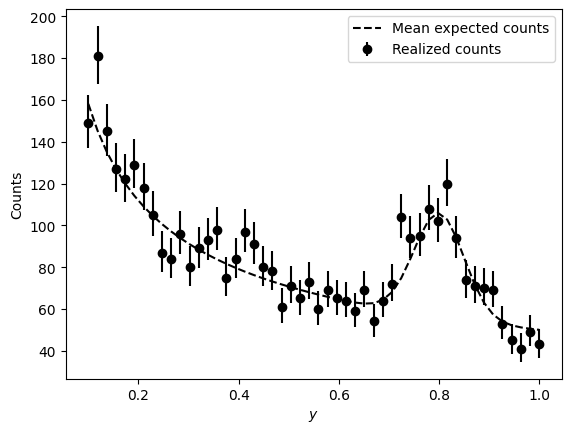

In [8]:
def poisson_interval(k, alpha=0.32): 
    """ Uses chi2 to get the poisson interval.
    """
    a = alpha
    low, high = (chi2.ppf(a/2, 2*k) / 2, chi2.ppf(1-a/2, 2*k + 2) / 2)
    if k == 0: 
        low = 0.0
    return k - low, high - k

y = np.linspace(0.1, 1, 50)  # Dependent variable

# Mean expected counts
x_mu = bump_forward_model(y, 
                    amp_s=50, mu_s=0.8, std_s=0.05,  # Signal params
                    amp_b=50, exp_b=-0.5)  # Background params

# Realized counts
x = np.random.poisson(x_mu)
x_err = np.array([poisson_interval(k) for k in x.T]).T

# Plot
plt.plot(y, x_mu, color='k', ls='--', label="Mean expected counts")
plt.errorbar(y, x, yerr=x_err, fmt='o', color='k', label="Realized counts")

plt.xlabel("$y$")
plt.ylabel("Counts")

plt.legend()

# plt.savefig("assets/x1.pdf")

## The explicit likelihood

In this case, we can write down a log-likelihood as a Poisson over the mean returned by the forward model.

In [9]:
def log_like(theta, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s, std_s) on top of a power-law background (amp_b, exp_b).
    """
    amp_s, mu_s, std_s, amp_b, exp_b = theta
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

Let's focus on just 2 parameters for simplicity, the signal amplitude and mean location. The likelihood in this case is:

In [10]:
def log_like_sig(params, y, x):
    """ Log-likehood function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = params
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    return poisson.logpmf(x, mu).sum()

log_like_sig([50, 0.8], y, x)

-184.4605159098972

Get a maximum-liklelihood estimate:

In [11]:
# Initial guess for the parameters
initial_guess = [100., 0.1]

# Set up the minimizer_kwargs for the basinhopping algorithm
minimizer_kwargs = {"method": "L-BFGS-B", "bounds": ((0, 200), (0, 1))}

# Perform the optimization using basinhopping
opt = basinhopping(lambda thetas: -log_like_sig(thetas, y, x), initial_guess, minimizer_kwargs=minimizer_kwargs)

print("MLE parameters: {}; true parameters: {}".format(opt.x, (50, 0.8)))


MLE parameters: [57.27420791  0.79195657]; true parameters: (50, 0.8)


And approximate posterior using `emcee`:

In [12]:
def log_prior(thetas):
    """ Log-prior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    amp_s, mu_s = thetas
    if 0 < amp_s < 200 and 0 < mu_s < 2:
        return 0
    else:
        return -np.inf
    
def log_post(thetas, y, x):
    """ Log-posterior function for a Gaussian bump (amp_s, mu_s) on top of a fixed PL background.
    """
    lp = log_prior(thetas)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like_sig(thetas, y, x)
    
# Sampling with `emcee`
ndim, nwalkers = 2, 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(y, x))

pos = opt.x + 1e-3 * np.random.randn(nwalkers, ndim)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:05<00:00, 920.82it/s]


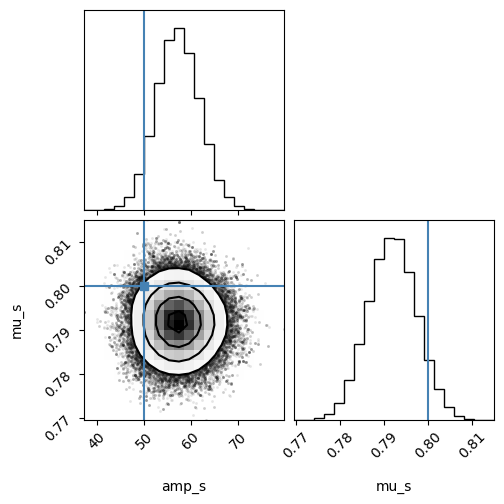

In [13]:
# Plot posterior samples
flat_samples = sampler.get_chain(discard=1000, flat=True)
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], smooth=1.);

## The implicit likelihood

Now we will do inference without relying on the explicit likelihood evaluation. The key realization is that samples from the forward model implicitly encode the likelihood; when we are simulating data points $x$ for different parameter points $\theta$, we are drawing samples from the likelihood:
$$x\sim p(x\mid\theta)$$
which is where the _implicit_ aspect comes from. Let's write down a bump simulator:

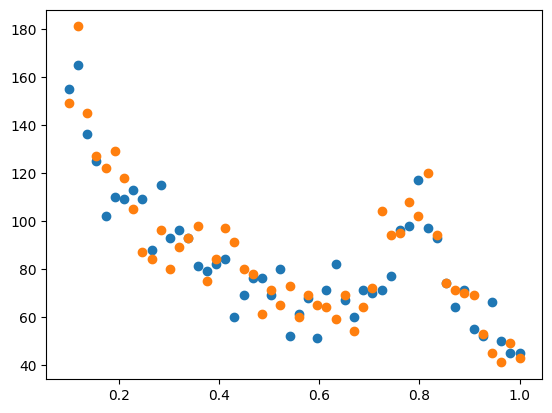

In [14]:
def bump_simulator(thetas, y):
    """ Simulate samples from the bump forward model given theta = (amp_s, mu_s) and abscissa points y.
    """
    amp_s, mu_s = thetas
    std_s, amp_b, exp_b = 0.05, 50, -0.5
    x_mu = bump_forward_model(y, amp_s, mu_s, std_s, amp_b, exp_b)
    x = np.random.poisson(x_mu)
    return x

# Test it out
bump_simulator([50, 0.8], y)

plt.scatter(y, bump_simulator([50, 0.8], y))
plt.scatter(y, x)

### Approximate Bayesian Computation (ABC)

<img src=./assets/abc.png alt= “” width=800>


The idea behind ABC is to realize samples from the forward model (with the parameters $\theta$ drawn from a prior) and compare it to the dataset of interest $x$. If the data and realized samples are close enough to each other according to some criterion, we keep the parameter points.

The comparison criterion here is a simple MSE on the data points. Play around with the parameters of the forward model to see how the criterion `eps` changes.

In [15]:
x_fwd = bump_simulator([50, 0.8], y)

eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)
eps

247.44

In [21]:
def abc(y, x, eps_thresh=200., n_samples=1000):
    """ABC algorithm for Gaussian bump model.

    Args:
        y (np.ndarray): Abscissa points.
        x (np.ndarray): Data counts.
        eps_thresh (float, optional): Acceptance threshold. Defaults to 500.0.
        n_samples (int, optional): Number of samples after which to stop. Defaults to 1000.

    Returns:
        np.ndarray: Accepted samples approximating the posterior p(theta|x).
    """
    samples = []
    total_attempts = 0
    progress_bar = tqdm(total=n_samples, desc="Accepted Samples", unit="samples")

    # Keep simulating until we have enough accepted samples
    while len(samples) < n_samples:
        params = np.random.uniform(low=[0, 0], high=[200, 1])  # Priors; theta ~ p(theta)
        x_fwd = bump_simulator(params, y)  # x ~ p(x|theta)
        eps = np.sum(np.abs(x - x_fwd) ** 2) / len(x)  # Distance metric; d(x, x_fwd)
        total_attempts += 1

        # If accepted, add to samples
        if eps < eps_thresh:
            samples.append(params)
            progress_bar.update(1)
            acceptance_ratio = len(samples) / total_attempts
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    return np.array(samples)

n_samples = 5_000
post_samples = abc(y, x, eps_thresh=200, n_samples=n_samples)

Accepted Samples: 100%|██████████| 5000/5000 [00:32<00:00, 151.55samples/s, acceptance_ratio=0.006]


Play around with the acceptance criterion `eps_thresh` to see how it affects the posterior.

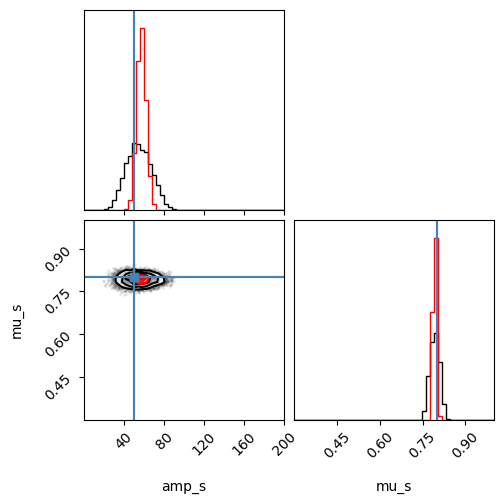

In [22]:
fig = corner.corner(post_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], range=[(0, 200), (0.3, 1)], bins=50);
corner.corner(flat_samples, labels=["amp_s", "mu_s"], truths=[50, 0.8], fig=fig, color="red", weights=np.ones(len(flat_samples)) * n_samples / len(flat_samples), range=[(0, 200), (0.3, 1)], bins=50);

Downsides of vanilla ABC:
- **How to summarize the data? Curse of dimensionality / loss of information.** In this case, the data is 1D, so we can just use the data points themselves, but for higher-dimensional data we would need to summarize it somehow.
- **How to compare with data? Likelihood may not be available.** In this case, we use a simple MSE, but this may not be particularly principled.
- **Choice of acceptance threshold: Precision/efficiency tradeoff.** Larger `eps_thresh` means more samples are accepted, but they might be a poor representation for the posterior. Smaller `eps_thresh` might mean a very small acceptance ratio, and thus a very inefficient sampler (may never converge).
- **Need to re-run pipeline for new data or new prior.**

Neural simulation-based inference methods (next notebook) address these issues.

<img src=./assets/header.png alt= “” width=600>